In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import yfinance as yf
import datetime as dt

from config import *

In [2]:
##api = tradeapi.REST(KEY_ID, SECRET_KEY,PAPER_URL,api_version='v2')
#Don't need this now!

In [3]:
#get data using yfinance
EndDay = dt.date.today()
StartDay = EndDay - dt.timedelta(days=2000)
YDF = yf.download('NKE',start=str(StartDay),end=str(EndDay))

[*********************100%***********************]  1 of 1 completed


In [5]:
#previewing
YDF.iloc[-10:]
YDF.loc['2020-01-06',:]

Open         1.009500e+02
High         1.018400e+02
Low          1.008700e+02
Close        1.018300e+02
Adj Close    1.015483e+02
Volume       4.612400e+06
Name: 2020-01-06 00:00:00, dtype: float64

In [6]:
#feed dataframe to cerbro
datacere = bt.feeds.PandasData(dataname=YDF)

datacere

In [7]:
#create backtrader
cerebro = bt.Cerebro()

In [8]:
#feed strat to cerebro
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )
    #Periods are in days since yf dataframe is by day, I THINK

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

            


In [9]:
cerebro.addstrategy(SmaCross)

0

In [10]:
#set up cerebro

cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=90)
#sizer tells cerebro how much to buy/sell at each buy/sell call. So this one is 90% of the cash, essentially. 
cerebro.adddata(datacere)


In [11]:
#create plotinfo dict for plotting options
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [12]:
#change window settings
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 15, 10 #Don't make the window wider than my screen please  
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

In [13]:
sma = bt.indicators.SimpleMovingAverage(datacere, period=15)
sma.plotinfo.plotname = 'mysma'
#Does this block do anything?

In [14]:

StartValue = cerebro.broker.getvalue()
# Run over everything
cerebro.run()
#Figure out if we made any money
EndValue = cerebro.broker.getvalue()
print('Started with {:2f}$ and Ended with {:2f}$'.format(StartValue,EndValue))

Started with 100000.000000$ and Ended with 105535.203981$


<IPython.core.display.Javascript object>


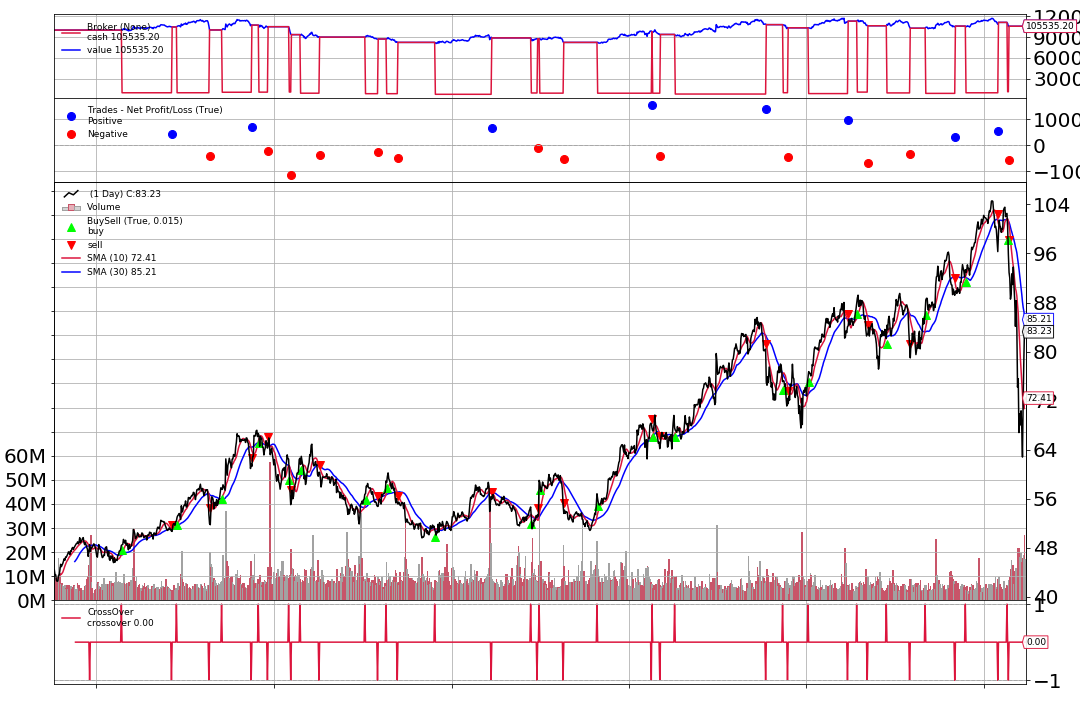

[[<Figure size 1080x720 with 5 Axes>]]

In [15]:
# Plot the result
cerebro.plot()